In [1]:
import os
import numpy as np
from keras import optimizers
from keras.callbacks import ModelCheckpoint, Callback
from keras.layers import Input, Embedding, LSTM, Dense, concatenate
from keras.models import Model, Sequential, load_model
from keras.layers.wrappers import TimeDistributed
from random import shuffle
import csv
import pickle
#from dictionaries import d_words_g
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import random
from pathlib import Path

In [4]:
import numpy as np
import gensim
import json
import csv

# Load Google's pre-trained Word2Vec model
model = gensim.models.KeyedVectors.load_word2vec_format(
    str(Path(os.getcwd()).parent.parent.parent.parent.parent) + '\\Downloads\\word2vec\\GoogleNews-vectors-negative300.bin', 
    binary=True)

# Load all Ding's words
with open(str(Path(os.getcwd()).parent) + '\\Data\\Ding_noun.csv', 'r') as f:
    nouns_ding = [row[0] for row in csv.reader(f)]

with open(str(Path(os.getcwd()).parent) + '\\Data\\Ding_adjective.csv', 'r') as f:
    adjs_ding = [row[0] for row in csv.reader(f)]

with open(str(Path(os.getcwd()).parent) + '\\Data\\Ding_verb.csv', 'r') as f:
    verbs_ding = [row[0] for row in csv.reader(f)]

words_ding = nouns_ding + adjs_ding + verbs_ding

# Get vector for every word and save
word_vectors_ding = []
for word in words_ding:
    vector = model[word]
    word_vectors_ding.append(vector)

# Make dictionary
dic_word2vec_ding = dict(zip(words_ding, word_vectors_ding))

# Save as a numpy file
np.save(str(Path(os.getcwd()).parent) + '\\Data\\dic_word2vec_ding_new.npy', dic_word2vec_ding)

# Test
d2 = np.load(str(Path(os.getcwd()).parent) + '\\Data\\dic_word2vec_ding_new.npy',allow_pickle=True)
print (d2.item().get('gray'))

[ 0.07617188  0.265625   -0.01470947 -0.04760742  0.1484375  -0.04321289
  0.01672363 -0.20214844  0.19726562  0.18261719  0.03369141  0.15722656
 -0.01611328 -0.12011719 -0.13671875 -0.15527344  0.00680542  0.4921875
 -0.14355469 -0.43554688 -0.18652344 -0.08837891 -0.12988281 -0.08496094
 -0.02441406 -0.02636719 -0.06176758  0.19628906 -0.11132812 -0.06738281
 -0.05932617  0.14941406  0.30273438 -0.01953125 -0.19726562 -0.06640625
  0.05541992 -0.02563477  0.05102539  0.02600098  0.06152344 -0.11767578
 -0.11621094 -0.11962891  0.2109375   0.19433594 -0.02600098 -0.13867188
 -0.05444336  0.07568359 -0.1328125   0.07226562  0.15332031  0.10986328
  0.12207031  0.04760742 -0.02429199 -0.00842285  0.01379395 -0.2265625
 -0.25       -0.06884766 -0.08544922 -0.25976562 -0.13671875  0.02868652
 -0.06835938  0.20800781 -0.04760742  0.16992188  0.32226562  0.01434326
 -0.01904297 -0.07080078 -0.20117188  0.04760742  0.26171875  0.11132812
  0.02282715  0.375       0.33007812 -0.19433594 -0.2

In [5]:
def participants_gen_with_end(synt_out=True, wave_out=False, repeat_words=True, train_gen=True):
    """Generates batches of sentences corresponding to the grammatical condition
    of Ding et all (2016). The Input words correspond to Word2Vec representations
    from Frank & Yang (2018).

    Input structure:    start, adj,  noun, verb, noun.
    Criteria structure: adj,   noun, verb, noun, end.

    Args:
        p_id: participant id. Determines the Word2Vec dictionary used for the input words.
        synt_out: if True adds a secondary syntactic vector to the criteria.
            This vector codes for the current syntactic structure: NP, VP, S.
        wave_out: if True adds a secondary vector of size 3 with sine waves at
            1hz, 2hz and 3hz to the criteria.
        repeat_words: if True words in the input sentences are repeated 4 times,
            otherwise filled with 'NONE' 3 times.

    Returns:
        A tuple of inputs and labels for training.
    """

    # Load dictionaries
    new_dict = np.load(str(Path(os.getcwd()).parent) + '\\Data\\dic_word2vec_ding_new.npy',allow_pickle=True)
    new_dict.item()['NONE'] = np.eye(new_dict.item()['cute'].shape[0])[0]
    new_dict.item()['END'] = np.eye(new_dict.item()['cute'].shape[0])[1]

    # Load words as lists
    with open(str(Path(os.getcwd()).parent) + '\\Data\\Ding_grammatical.csv', 'r') as f:
        sentence_list = [row for row in csv.reader(f)]

    while True:
        # Shuffle sentence list every time
        shuffle(sentence_list)

        # Lists to store inputs and labels
        input_batch = []
        output_batch = []
        synt_codes_batch = []

        for ind,sent in enumerate(sentence_list):
            # Repeat words or fill with 'NONE'
            if repeat_words:
                # 50 ms sample time, 20 samples/second
                input_words = [sent[0], sent[0], sent[0], sent[0], sent[0],
                               sent[1], sent[1], sent[1], sent[1], sent[1],
                               sent[2], sent[2], sent[2], sent[2], sent[2],
                               sent[3], sent[3], sent[3], sent[3], sent[3]]
                

            else:                
                input_words = ['NONE', 'NONE', 'NONE', 'NONE', sent[0],
                               'NONE', 'NONE', 'NONE', 'NONE', sent[1],
                               'NONE', 'NONE', 'NONE', 'NONE', sent[2],
                               'NONE', 'NONE', 'NONE', 'NONE', sent[3]]
                               
            
            output_words = [sent[0], sent[0], sent[0], sent[0], sent[1],
                            sent[1], sent[1], sent[1], sent[1], sent[2],
                            sent[2], sent[2], sent[2], sent[2], sent[3],
                            sent[3], sent[3], sent[3], sent[3], 'END']
            
            
            
            # Generate one-hot representation of words for output (the model takes as input the indexes directly)
            input_vectors = [new_dict.item().get(word) for word in input_words]
            output_vectors = [np.eye(len(new_dict.item().keys()))[list(new_dict.item().keys()).index(word)] for word in output_words]

            # Append to batch lists
            input_batch.append(input_vectors)
            output_batch.append(output_vectors)

        # split into train and test data generator
        if train_gen == True:
            yield np.array(input_batch[0:]),np.array(output_batch[0:])
        else:
            yield np.array(input_batch[50:]),np.array(output_batch[50:])

In [7]:
temp = participants_gen_with_end(synt_out=False,wave_out=False,train_gen=True,repeat_words=False)
temp1 = next(temp)

In [8]:
def gen_wordlist(len_wordlist=60,repeat_words=False):
    """Generates wordlist as opposed to sentences in participant_gen.

    output structure:    start, w1,w2,w3,w4.
    """
    # Assign dictionary based on participant id
    new_dict = np.load(str(Path(os.getcwd()).parent) + '\\Data\\dic_word2vec_ding_new.npy', allow_pickle=True)
    new_dict.item()['NONE'] = np.eye(new_dict.item()['cute'].shape[0])[0]
    new_dict.item()['END'] = np.eye(new_dict.item()['cute'].shape[0])[1]
    while True:
        # Lists to store inputs and labels
        wordlist_batch = []
        all_words = new_dict.item().keys()
        # randomly sample 4 words from p_dic.keys()
        wordlist_sentences = [random.sample(all_words,4) for i in range(len_wordlist)]
        for sent in wordlist_sentences:
            if repeat_words:
                input_words = ['START', 'NONE', 'NONE', 'NONE', sent[0],
                               sent[0], sent[0], sent[0], sent[0], sent[1],
                               sent[1], sent[1], sent[1], sent[1], sent[1],
                               sent[2], sent[2], sent[2], sent[2], sent[3]]

            else:
                '''
                input_words = ['NONE', sent[0], sent[0], sent[0], sent[0],
                               'NONE', sent[1], sent[1], sent[1], sent[1],
                               'NONE', sent[2], sent[2], sent[2], sent[2],
                               'NONE', sent[3], sent[3], sent[3], sent[3]]
                '''
                input_words = ['NONE', 'NONE', 'NONE', 'NONE', sent[0],
                            'NONE', 'NONE', 'NONE', 'NONE', sent[1],
                            'NONE', 'NONE', 'NONE', 'NONE', sent[2],
                            'NONE', 'NONE', 'NONE', 'NONE', sent[3]]
                
            input_vectors = [new_dict.item().get(word) for word in input_words]
            #noise = np.random.normal(0,.00125,334)
            #input_vectors = [v + noise for v in input_vectors]
            #input_vectors = np.array(input_vectors)
            #print(input_vectors.shape)
            # Append to batch lists
            wordlist_batch.append(input_vectors)
        yield np.array(wordlist_batch)        

In [9]:
n_samples = 60
wordlist_data = next(gen_wordlist(len_wordlist=n_samples))
print(wordlist_data.shape)

(60, 20, 300)


In [10]:
def gen_nonsense_grammatical(len_samples=60,repeat_words=False):
    # get the nouns, adjectives, and verbs
    adjectives = list(np.genfromtxt(str(Path(os.getcwd()).parent) + '\\Data\\Ding_adjective.csv',dtype=str))
    nouns = list(np.genfromtxt(str(Path(os.getcwd()).parent) + '\\Data\\Ding_noun.csv',dtype=str))
    verbs = list(np.genfromtxt(str(Path(os.getcwd()).parent) + '\\Data\\Ding_verb.csv',dtype=str))
    sentences_batch = []
    
    # Assign dictionary based on participant id
    new_dict = np.load(str(Path(os.getcwd()).parent) + '\\Data\\dic_word2vec_ding_new.npy',allow_pickle=True)
    new_dict.item()['NONE'] = np.eye(new_dict.item()['cute'].shape[0])[0]
    new_dict.item()['END'] = np.eye(new_dict.item()['cute'].shape[0])[1]
    for i in range(len_samples):
        w1,w2,w3,w4 = '','','',''
        while w1 not in new_dict.item().keys():
            w1 = random.sample(adjectives,1)[0]
        while w2 not in new_dict.item().keys():
            w2 = random.sample(nouns,1)[0]
        while w3 not in new_dict.item().keys():
            w3 = random.sample(verbs,1)[0]
        while w4 not in new_dict.item().keys():
            w4 = random.sample(nouns,1)[0]
        sent = [w1,w2,w3,w4]
        if repeat_words:
            input_words = ['START', 'NONE', 'NONE', 'NONE', sent[0],
                            sent[0], sent[0], sent[0], sent[0], sent[1],
                            sent[1], sent[1], sent[1], sent[1], sent[1],
                            sent[2], sent[2], sent[2], sent[2], sent[3]]

        else:
            input_words = ['NONE', 'NONE', 'NONE', 'NONE', sent[0],
                            'NONE', 'NONE', 'NONE', 'NONE', sent[1],
                            'NONE', 'NONE', 'NONE', 'NONE', sent[2],
                            'NONE', 'NONE', 'NONE', 'NONE', sent[3]]
            
        #input_vectors = [p_dic[word] for word in input_words]
        #noise = np.random.normal(0,.00125,334)
        #input_vectors = [v + noise for v in input_vectors]
        input_vectors = [new_dict.item().get(word) for word in input_words]

        sentences_batch.append(input_vectors)
    yield np.array(sentences_batch)    

In [11]:
print(next(gen_nonsense_grammatical()).shape)

(60, 20, 300)


In [12]:
def gen_nphrases(len_samples=60,repeat_words=False):
    # get the nouns, adjectives, and verbs
    adjectives = list(np.genfromtxt(str(Path(os.getcwd()).parent) + '\\Data\\Ding_adjective.csv',dtype=str))
    nouns = list(np.genfromtxt(str(Path(os.getcwd()).parent) + '\\Data\\Ding_noun.csv',dtype=str))
    verbs = list(np.genfromtxt(str(Path(os.getcwd()).parent) + '\\Data\\Ding_verb.csv',dtype=str))
    sentences_batch = []

    # Assign dictionary based on participant id
    new_dict = np.load(str(Path(os.getcwd()).parent) + '\\Data\\dic_word2vec_ding_new.npy',allow_pickle=True)
    new_dict.item()['NONE'] = np.eye(new_dict.item()['cute'].shape[0])[0]
    new_dict.item()['END'] = np.eye(new_dict.item()['cute'].shape[0])[1]
    for i in range(len_samples):
        w1,w2,w3,w4 = '','','',''
        while w1 not in new_dict.item().keys():
            w1 = random.sample(adjectives,1)[0]
        while w2 not in new_dict.item().keys():
            w2 = random.sample(nouns,1)[0]
        while w3 not in new_dict.item().keys():
            w3 = random.sample(adjectives,1)[0]
        while w4 not in new_dict.item().keys():
            w4 = random.sample(nouns,1)[0]
        sent = [w1,w2,w3,w4]
        if repeat_words:
            input_words = ['START', 'NONE', 'NONE', 'NONE', sent[0],
                            sent[0], sent[0], sent[0], sent[0], sent[1],
                            sent[1], sent[1], sent[1], sent[1], sent[1],
                            sent[2], sent[2], sent[2], sent[2], sent[3]]

        else:
            input_words = ['NONE', 'NONE', 'NONE', 'NONE', sent[0],
                            'NONE', 'NONE', 'NONE', 'NONE', sent[1],
                            'NONE', 'NONE', 'NONE', 'NONE', sent[2],
                            'NONE', 'NONE', 'NONE', 'NONE', sent[3]]
            
        #input_vectors = [p_dic[word] for word in input_words]
        #noise = np.random.normal(0,.00125,334)
        #input_vectors = [v + noise for v in input_vectors]
        input_vectors = [new_dict.item().get(word) for word in input_words]
        sentences_batch.append(input_vectors)
    yield np.array(sentences_batch)    

In [13]:
print(next(gen_nphrases()).shape)

(60, 20, 300)


In [14]:
def gen_vphrases(len_samples=60,repeat_words=False):
    # get the nouns, adjectives, and verbs
    adjectives = list(np.genfromtxt(str(Path(os.getcwd()).parent) + '\\Data\\Ding_adjective.csv',dtype=str))
    nouns = list(np.genfromtxt(str(Path(os.getcwd()).parent) + '\\Data\\Ding_noun.csv',dtype=str))
    verbs = list(np.genfromtxt(str(Path(os.getcwd()).parent) + '\\Data\\Ding_verb.csv',dtype=str))
    sentences_batch = []

    # Assign dictionary based on participant id
    new_dict = np.load(str(Path(os.getcwd()).parent) + '\\Data\\dic_word2vec_ding_new.npy',allow_pickle=True)
    new_dict.item()['NONE'] = np.eye(new_dict.item()['cute'].shape[0])[0]
    new_dict.item()['END'] = np.eye(new_dict.item()['cute'].shape[0])[1]
    for i in range(len_samples):
        w1,w2,w3,w4 = '','','',''
        while w1 not in new_dict.item().keys():
            w1 = random.sample(verbs,1)[0]
        while w2 not in new_dict.item().keys():
            w2 = random.sample(nouns,1)[0]
        while w3 not in new_dict.item().keys():
            w3 = random.sample(verbs,1)[0]
        while w4 not in new_dict.item().keys():
            w4 = random.sample(nouns,1)[0]
        sent = [w1,w2,w3,w4]
        if repeat_words:
            input_words = ['START', 'NONE', 'NONE', 'NONE', sent[0],
                            sent[0], sent[0], sent[0], sent[0], sent[1],
                            sent[1], sent[1], sent[1], sent[1], sent[1],
                            sent[2], sent[2], sent[2], sent[2], sent[3]]

        else:
            input_words = ['NONE', 'NONE', 'NONE', 'NONE', sent[0],
                            'NONE', 'NONE', 'NONE', 'NONE', sent[1],
                            'NONE', 'NONE', 'NONE', 'NONE', sent[2],
                            'NONE', 'NONE', 'NONE', 'NONE', sent[3]]
        #input_vectors = [p_dic[word] for word in input_words]
        #noise = np.random.normal(0,.00125,334)
        #input_vectors = [v + noise for v in input_vectors]
        input_vectors = [new_dict.item().get(word) for word in input_words]
        sentences_batch.append(input_vectors)
    yield np.array(sentences_batch)    

In [15]:
print(next(gen_vphrases()).shape)

(60, 20, 300)


In [16]:
def gen_rpatterns(len_samples=60,repeat_words=False):
    # get the nouns, adjectives, and verbs
    adjectives = list(np.genfromtxt(str(Path(os.getcwd()).parent) + '\\Data\\Ding_adjective.csv',dtype=str))
    nouns = list(np.genfromtxt(str(Path(os.getcwd()).parent) + '\\Data\\Ding_noun.csv',dtype=str))
    verbs = list(np.genfromtxt(str(Path(os.getcwd()).parent) + '\\Data\\Ding_verb.csv',dtype=str))
    sentences_batch = []

    # Assign dictionary based on participant id
    new_dict = np.load(str(Path(os.getcwd()).parent) + '\\Data\\dic_word2vec_ding_new.npy',allow_pickle=True)
    new_dict.item()['NONE'] = np.eye(new_dict.item()['cute'].shape[0])[0]
    new_dict.item()['END'] = np.eye(new_dict.item()['cute'].shape[0])[1]
    for i in range(len_samples):
        w1,w2,w3,w4 = '','','',''
        while w1 not in new_dict.item().keys():
            w1 = random.sample(verbs,1)[0]
        while w2 not in new_dict.item().keys():
            w2 = random.sample(nouns,1)[0]
        while w3 not in new_dict.item().keys():
            w3 = random.sample(nouns,1)[0]
        while w4 not in new_dict.item().keys():
            w4 = random.sample(adjectives,1)[0]
        sent = [w1,w2,w3,w4]
        if repeat_words:
            input_words = ['START', 'NONE', 'NONE', 'NONE', sent[0],
                            sent[0], sent[0], sent[0], sent[0], sent[1],
                            sent[1], sent[1], sent[1], sent[1], sent[1],
                            sent[2], sent[2], sent[2], sent[2], sent[3]]

        else:
            input_words = ['NONE', 'NONE', 'NONE', 'NONE', sent[0],
                            'NONE', 'NONE', 'NONE', 'NONE', sent[1],
                            'NONE', 'NONE', 'NONE', 'NONE', sent[2],
                            'NONE', 'NONE', 'NONE', 'NONE', sent[3]]
            
        #input_vectors = [p_dic[word] for word in input_words]
        #noise = np.random.normal(0,.00125,334)
        #input_vectors = [v + noise for v in input_vectors]
        input_vectors = [new_dict.item().get(word) for word in input_words]
        sentences_batch.append(input_vectors)
    yield np.array(sentences_batch)    

In [48]:
# let us now try to predict the np - vp 
PID = 11
new_dict = np.load(str(Path(os.getcwd()).parent) + '\\Data\\dic_word2vec_ding_new.npy',allow_pickle=True)
new_dict.item()['NONE'] = np.eye(new_dict.item()['cute'].shape[0])[0]
new_dict.item()['END'] = np.eye(new_dict.item()['cute'].shape[0])[1]

VOCAB = len(new_dict.item().keys())
train_data_gen = participants_gen_with_end(synt_out=False,wave_out=False,train_gen=True,repeat_words=False)
test_data_gen = participants_gen_with_end(synt_out=False,wave_out=False,train_gen=False,repeat_words=False)
model = Sequential()
model.add(LSTM(100,input_shape=(20,300),return_sequences=True,name='lstm'))
model.add(Dense(VOCAB, name='word_pred_1'))
nadam = optimizers.Nadam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08,
                         schedule_decay=0.004)
model.compile(loss='mean_squared_error', optimizer=nadam)
print(model.summary())
model.fit_generator(generator=train_data_gen, steps_per_epoch=100, epochs=10,
                                         verbose=1)

model.save(str(Path(os.getcwd()).parent) + '\\Data\\models\\not_repeated_with_end_new.h5')
# train LSTM

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 100)           160400    
_________________________________________________________________
word_pred_1 (Dense)          (None, 20, 329)           33229     
Total params: 193,629
Trainable params: 193,629
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
100/100 [==============================] - 57s 566ms/step - loss: 0.0021
Epoch 2/10
100/100 [==============================] - 54s 541ms/step - loss: 0.0016
Epoch 3/10
100/100 [==============================] - 53s 529ms/step - loss: 0.0016
Epoch 4/10
100/100 [==============================] - 52s 523ms/step - loss: 0.0016
Epoch 5/10
100/100 [==============================] - 52s 520ms/step - loss: 0.0016
Epoch 6/10
100/100 [==============================] - 52s 516ms/step - loss: 0.0015
E

OSError: Unable to create file (unable to open file: name = 'C:\Users\karkau\Documents\karthikeya\rnn_project\custom_code\Code\Data\models\not_repeated_with_end_new.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 302)

In [17]:
model = load_model(str(Path(os.getcwd()).parent) + '\\Data\\models\\not_repeated_with_end_new.h5')

In [18]:
# power spectra function
def power_spectra(w2vec_array, sampling_rate=16):
    """Computes power spectra using the Discrete Fourier Transform.

    Args:
        w2vec_array: arrays of shape (n_sentences*time_steps, n_units)
            representing hidden layer activations in response to each word of the
            concatenated sequence of sentences.
        sample_rate: number of measures (outputs of the model) per second.

    Returns:
        Mean power spectra and frequency axis.
    """

    # Separate each unit and concatenate across words to form 1 vector per unit
    unit_vectors = np.transpose(w2vec_array)

    # Frequency domain
    # num_samples is just the number of data points for each unit
    num_samples = unit_vectors.shape[1]
    freq = np.fft.rfftfreq(num_samples, d=1./sampling_rate)
    print ('freq ' ,freq.shape)
    # Calculate the FFT and power spectra for each unit
    units_ps = []
    for vector in unit_vectors:
        ft_unit = np.fft.rfft(vector)  # fft
        ps_uni = np.abs(ft_unit) ** 2  # power spectrum
        units_ps.append(ps_uni)

    # Average power spectra over units
    mean_ps = np.mean(units_ps, axis=0)
    print ('mean_ps',mean_ps.shape)
    return freq, mean_ps

In [19]:
def plot_results(plot_path, freq, power, act,sampling_rate=16,n_samples=60,title='Input stimuli',smoothed=True):
    """Plot all the results of one condition"""
    plt.rcParams['pdf.fonttype'] = 42 # for the eps files
    plt.rcParams['ps.fonttype'] = 42

    # Time domain parameters
    sampling_interval = 1.0/sampling_rate  # sampling interval
    t = np.arange(0, n_samples, sampling_interval)  # time vector
    # Build plot
    fig, ax = plt.subplots(nrows=2, ncols=1)
    fig.suptitle(title)
    ax[0].plot(t, act, linewidth=1.0)
    # Axis labels
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('Amplitude')
    until_4 = np.where(freq==4)[0][0]
    print('Power difference ')
    #if smoothed == True:
    #    power = np.convolve(power, np.ones((50,))/50, mode='valid')
    ax[1].plot(freq[1:until_4+50], (power[1:until_4+50]), 'r', linewidth=1.0)
    ax[1].set_xlabel('Freq (Hz)')
    #ax[1].set_ylim([-1000, 9000])
    ax[1].set_ylabel('Power (db)')
    # Adjusts subplot
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    # Save
    fig.savefig(plot_path+'.pdf')


In [20]:
def windowed_zscores(vals,window=10):
    scores = np.zeros(vals.shape)
    seq_length = vals.shape[0]
    for i in range(seq_length):
        # before window length is reached
        if i < window:
            scores[i] = vals[i] - np.concatenate([vals[i+1:i+1+window],vals[0:i]]).mean()
        # less than window length remaining
        elif (i + window) > seq_length:
            scores[i] = vals[i] - np.concatenate([vals[i-window:i],vals[i+1:]]).mean()
        # after window length is reached
        else:
            scores[i] = vals[i] - np.concatenate([vals[i+1:i+1+window],vals[i-window:i]]).mean()
    return scores

freq  (601,)
mean_ps (601,)
Power difference 


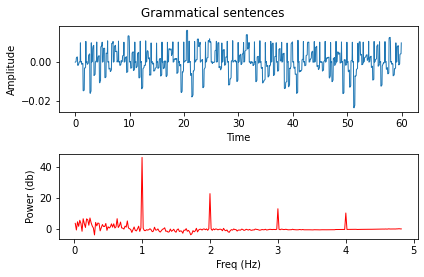

In [24]:
n_samples = 60
PID = 0
train_data_gen = participants_gen_with_end(synt_out=False,wave_out=False,train_gen=True,repeat_words=False)
train_data = next(train_data_gen)[0]

lstm_model = Model(inputs=model.input,outputs=model.get_layer('lstm').output)
lstm_outputs = lstm_model.predict_on_batch(train_data)
activations = np.reshape(lstm_outputs, (n_samples * 20, 100))
embedded_inputs = np.reshape(train_data,(n_samples * 20, train_data.shape[2]))
freq,mean_ps = power_spectra(activations,sampling_rate=20)
mean_ps = windowed_zscores(vals=mean_ps,window=50)

data_storage_path = str(Path(os.getcwd()).parent) + '\\Data\\data-vals\\valid_sentences\\'
np.save(data_storage_path + 'freq.npy',freq)
np.save(data_storage_path + 'mean_power.npy',mean_ps)
np.save(data_storage_path + 'activations.npy',np.mean(activations,axis=1))

plot_results(str(Path(os.getcwd()).parent) + '\\Data\\plots-smoothed\\grammatical', freq,power=mean_ps, 
             act=np.mean(activations,axis=1),sampling_rate=20,n_samples=n_samples,title='Grammatical sentences')


(60, 20, 300)
freq  (601,)
mean_ps (601,)
Power difference 


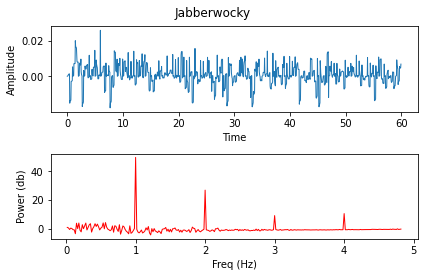

In [26]:
n_samples = 60
test_data_gen = gen_nonsense_grammatical(repeat_words=False,len_samples=n_samples)
#participants_gen(p_id=PID,synt_out=False,wave_out=False,train_gen=False)
test_data = next(test_data_gen)
print(test_data.shape)
lstm_model = Model(inputs=model.input,outputs=model.get_layer('lstm').output)
lstm_outputs = lstm_model.predict_on_batch(test_data)
activations = np.reshape(lstm_outputs, (n_samples * 20, 100))
embedded_inputs = np.reshape(test_data,(n_samples * 20, test_data.shape[2]))
freq,mean_ps = power_spectra(activations,sampling_rate=20)
mean_ps = windowed_zscores(vals=mean_ps,window=50)

data_storage_path = str(Path(os.getcwd()).parent) + '\\Data\\data-vals\\jabberwocky\\'
np.save(data_storage_path + 'freq.npy',freq)
np.save(data_storage_path + 'mean_power.npy',mean_ps)
np.save(data_storage_path + 'activations.npy',np.mean(activations,axis=1))

plot_results(str(Path(os.getcwd()).parent) + '\\Data\\plots-smoothed\\jabberwocky', freq,power=mean_ps, 
             act=np.mean(activations,axis=1),sampling_rate=20,n_samples=n_samples,title='Jabberwocky')

(60, 20, 300)
freq  (601,)
mean_ps (601,)
Power difference 


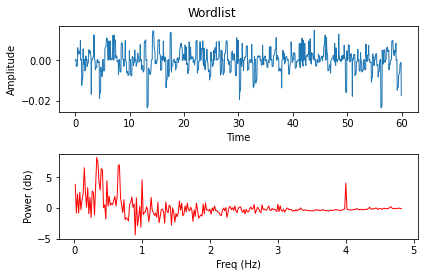

In [31]:
# test for wordlist :
n_samples = 60
wordlist_data = next(gen_wordlist(len_wordlist=n_samples))
print(wordlist_data.shape)
lstm_model = Model(inputs=model.input,outputs=model.get_layer('lstm').output)
lstm_wordlist_output = lstm_model.predict_on_batch(wordlist_data)
activations = np.reshape(lstm_wordlist_output, (n_samples * 20, 100))
embedded_inputs = np.reshape(wordlist_data,(n_samples * 20, wordlist_data.shape[2]))
freq,mean_ps = power_spectra(activations,sampling_rate=20)
mean_ps = windowed_zscores(vals=mean_ps,window=50)

data_storage_path = str(Path(os.getcwd()).parent) + '\\Data\\data-vals\\word_salad\\'
np.save(data_storage_path + 'freq.npy',freq)
np.save(data_storage_path + 'mean_power.npy',mean_ps)
np.save(data_storage_path + 'activations.npy',np.mean(activations,axis=1))

plot_results(str(Path(os.getcwd()).parent) + '\\Data\\plots-smoothed\\wordlist', freq,power=mean_ps, 
             act=np.mean(activations,axis=1),sampling_rate=20,n_samples=n_samples,title='Wordlist')


(60, 20, 300)
freq  (601,)
mean_ps (601,)
Power difference 


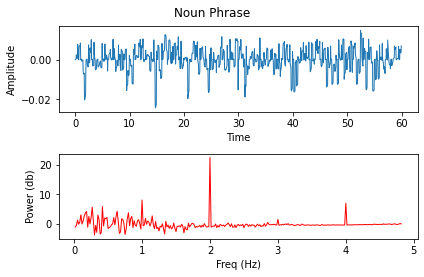

In [32]:
# now check for phrasal completion spectrum
# noun phrases :
n_samples = 60
nphrase_data = next(gen_nphrases(len_samples=n_samples))
print(wordlist_data.shape)
lstm_model = Model(inputs=model.input,outputs=model.get_layer('lstm').output)
lstm_nphrase_output = lstm_model.predict_on_batch(nphrase_data)
activations = np.reshape(lstm_nphrase_output, (n_samples * 20, 100))
embedded_inputs = np.reshape(nphrase_data,(n_samples * 20, nphrase_data.shape[2]))
freq,mean_ps = power_spectra(activations,sampling_rate=20)
mean_ps = windowed_zscores(vals=mean_ps,window=50)

data_storage_path = str(Path(os.getcwd()).parent) + '\\Data\\data-vals\\noun_phrases\\'
np.save(data_storage_path + 'freq.npy',freq)
np.save(data_storage_path + 'mean_power.npy',mean_ps)
np.save(data_storage_path + 'activations.npy',np.mean(activations,axis=1))

plot_results(str(Path(os.getcwd()).parent) + '\\Data\\plots-smoothed\\noun_phrases', freq,power=mean_ps, 
             act=np.mean(activations,axis=1),sampling_rate=20,n_samples=n_samples,title='Noun Phrase')

(60, 20, 300)
freq  (601,)
mean_ps (601,)
Power difference 


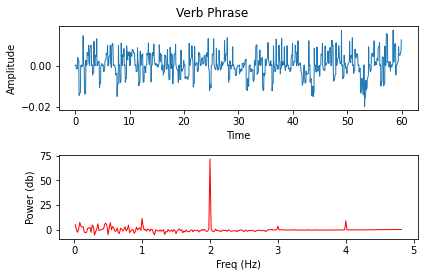

In [33]:
# now check for phrasal completion spectrum
# verb phrases :
n_samples = 60
vphrase_data = next(gen_vphrases(len_samples=n_samples))
print(vphrase_data.shape)
lstm_model = Model(inputs=model.input,outputs=model.get_layer('lstm').output)
lstm_vphrase_output = lstm_model.predict_on_batch(vphrase_data)
activations = np.reshape(lstm_vphrase_output, (n_samples * 20, 100))
embedded_inputs = np.reshape(vphrase_data,(n_samples * 20, vphrase_data.shape[2]))
freq,mean_ps = power_spectra(activations,sampling_rate=20)
mean_ps = windowed_zscores(vals=mean_ps,window=50)

data_storage_path = str(Path(os.getcwd()).parent) + '\\Data\\data-vals\\verb_phrases\\'
np.save(data_storage_path + 'freq.npy',freq)
np.save(data_storage_path + 'mean_power.npy',mean_ps)
np.save(data_storage_path + 'activations.npy',np.mean(activations,axis=1))

plot_results(str(Path(os.getcwd()).parent) + '\\Data\\plots-smoothed\\verb_phrases', freq,power=mean_ps, 
             act=np.mean(activations,axis=1),sampling_rate=20,n_samples=n_samples,title='Verb Phrase')

(60, 20, 300)
freq  (601,)
mean_ps (601,)
Power difference 


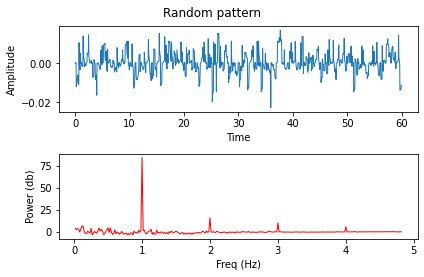

In [34]:
# now check for phrasal completion spectrum
# verb phrases :
n_samples = 60
rpattern_data = next(gen_rpatterns(len_samples=n_samples))
print(rpattern_data.shape)
lstm_model = Model(inputs=model.input,outputs=model.get_layer('lstm').output)
lstm_rpattern_output = lstm_model.predict_on_batch(rpattern_data)
activations = np.reshape(lstm_rpattern_output, (n_samples * 20, 100))
embedded_inputs = np.reshape(rpattern_data,(n_samples * 20, rpattern_data.shape[2]))
freq,mean_ps = power_spectra(activations,sampling_rate=20)
mean_ps = windowed_zscores(vals=mean_ps,window=50)

data_storage_path = str(Path(os.getcwd()).parent) + '\\Data\\data-vals\\random_pattern\\'
np.save(data_storage_path + 'freq.npy',freq)
np.save(data_storage_path + 'mean_power.npy',mean_ps)
np.save(data_storage_path + 'activations.npy',np.mean(activations,axis=1))

plot_results(str(Path(os.getcwd()).parent) + '\\Data\\plots-smoothed\\random_pattern', freq,power=mean_ps, 
             act=np.mean(activations,axis=1),sampling_rate=20,n_samples=n_samples,title='Random pattern')